# 네이버 쇼핑 리뷰 감성분류 - GRU

- Mecab 설치

In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 24.53 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 54.0 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-01-26 06:45:23--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loc

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = 'https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt'
df = pd.read_table(url, names=['ratings', 'reviews'])
df.head(3)

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...


In [4]:
# 평점이 4, 5 점인 데이터를 1 (긍정)
df['label'] = df.apply(lambda x: 1 if x.ratings > 3 else 0, axis=1)
df.head()

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [5]:
# 각 열별로 중복 확인
df.shape, df.ratings.nunique(), df.reviews.nunique()

((200000, 3), 4, 199908)

- 데이터 전처리

In [6]:
# 중복 제거
df.drop_duplicates(subset=['reviews'], inplace=True)
df.shape

(199908, 3)

In [7]:
# Null 값 확인 - 0이 나오면 결측치가 없음
df.isnull().sum().sum()

0

- 한글 이외의 데이터는 제거

In [8]:
df.reviews = df.reviews.str.replace('[^ㄱ-ㅎㅏ-ㅣ-가-힣 ]', '')

In [9]:
# Null 데이터가 생기면 제거
df.reviews.replace('', np.nan, inplace=True)
df.reviews.isnull().sum()

0

- 훈련/테스트 데이터셋 분리

In [10]:
# 훈련 데이터 : 테스트 데이터 = 3 : 1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.reviews.values, df.label.values, stratify=df.label.values, 
    test_size=0.25, random_state=2022
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((149931,), (49977,), (149931,), (49977,))

In [11]:
# 훈련 데이터 레이블의 분포
np.unique(y_train, return_counts=True)

(array([0, 1]), array([74966, 74965]))

- 토큰화

In [12]:
from konlpy.tag import Mecab

In [13]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [14]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [15]:
X_train = [mecab.morphs(review) for review in X_train]
X_train = list(map(lambda s: [item for item in s if item not in stopwords], X_train))

In [16]:
'''tokenized_list = []
for review in X_train:
    morphs = mecab.morphs(review)
    morphs = [item for item in morphs if item not in stopwords]
    tokenized_list.append(morphs)
X_train = tokenized_list'''

'tokenized_list = []\nfor review in X_train:\n    morphs = mecab.morphs(review)\n    morphs = [item for item in morphs if item not in stopwords]\n    tokenized_list.append(morphs)\nX_train = tokenized_list'

In [17]:
print(X_train[0])

['완전', '예뻐요', '겁나', '만족']


In [18]:
X_test = [mecab.morphs(review) for review in X_test]
X_test = list(map(lambda s: [item for item in s if item not in stopwords], X_test))

In [19]:
print(X_test[0])

['배송', '빠르', '잘', '포장', '되', '어서', '왔', '네요', '번창', '세요']


- 단어와 길이 분포 확인하기

In [20]:
positive_words = []
for i in range(len(y_train)):
    if y_train[i] == 1:
        positive_words += X_train[i]

In [21]:
[1, 2, 3] + [4, 5]

[1, 2, 3, 4, 5]

In [22]:
from collections import Counter
Counter(['a', 'b', 'a'])

Counter({'a': 2, 'b': 1})

In [23]:
positive_words_count = Counter(positive_words)
len(positive_words)

1019483

In [24]:
print(positive_words_count.most_common(20))

[('좋', 39734), ('아요', 21339), ('네요', 19951), ('어요', 18566), ('잘', 18437), ('구매', 16219), ('습니다', 13432), ('있', 12343), ('배송', 12244), ('는데', 11604), ('했', 9806), ('합니다', 9732), ('먹', 9697), ('재', 9335), ('너무', 8492), ('같', 7843), ('만족', 7296), ('거', 6555), ('어', 6315), ('쓰', 6231)]


In [25]:
negative_words = []
for i in range(len(y_train)):
    if y_train[i] == 0:
        negative_words += X_train[i]

In [26]:
negative_words_count = Counter(negative_words)
print(negative_words_count.most_common(20))

[('네요', 31795), ('는데', 20333), ('안', 19769), ('어요', 14728), ('너무', 13255), ('있', 13101), ('했', 11783), ('좋', 9712), ('배송', 9669), ('같', 8995), ('구매', 8877), ('어', 8858), ('거', 8832), ('아요', 8753), ('없', 8745), ('되', 8414), ('그냥', 8402), ('습니다', 8394), ('잘', 8104), ('않', 7972)]


- 인코딩

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

tok = Tokenizer()
tok.fit_on_texts(X_train)

In [28]:
threshold = 2
total_cnt = len(tok.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [29]:
for key, value in tok.word_counts.items():
    total_freq = value
    if value < threshold:       # 단어의 등장 빈도가 threshold보다 작을 경우
        rare_cnt += 1
        rare_freq += value

In [30]:
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print(f'등장 빈도가 {threshold -1}번 이하인 희귀 단어의 수: {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40031
등장 빈도가 1번 이하인 희귀 단어의 수: 18218
단어 집합에서 희귀 단어의 비율: 45.50972995928156
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1821800.0


- 등장 빈도가 2회 이하인 단어는 제외

In [31]:
# 0번 패딩 토큰과 1번 OOV(Out-of-Value) 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
vocab_size

21815

In [32]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 패딩

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.3271438194903


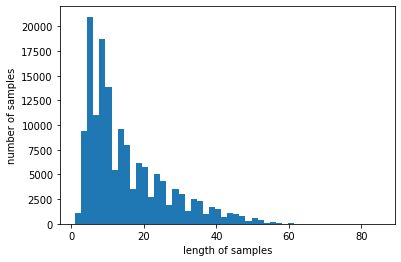

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
# 리뷰 길이를 60으로 패딩
max_len = 60

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### GRU로 감성 분류
- 임베딩 벡터의 차원: 100
- 은닉 상태의 크기: 128

In [37]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [38]:
model = Sequential([ 
    Embedding(vocab_size, 100, input_length=max_len),
    GRU(128),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           2181500   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,269,949
Trainable params: 2,269,949
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])

model_path = 'best-shopping-gru.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [40]:
hist = model.fit(X_train, y_train, epochs=30, batch_size=128, 
                 validation_split=0.2, callbacks=[mc, es])

Epoch 1/30
937/938 [============================>.] - ETA: 0s - loss: 0.2907 - accuracy: 0.8886
Epoch 00001: val_loss improved from inf to 0.24530, saving model to best-shopping-gru.h5
938/938 [==============================] - 18s 12ms/step - loss: 0.2907 - accuracy: 0.8886 - val_loss: 0.2453 - val_accuracy: 0.9094
Epoch 2/30
936/938 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9266
Epoch 00002: val_loss improved from 0.24530 to 0.22538, saving model to best-shopping-gru.h5
938/938 [==============================] - 11s 11ms/step - loss: 0.2077 - accuracy: 0.9266 - val_loss: 0.2254 - val_accuracy: 0.9178
Epoch 3/30
936/938 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9398
Epoch 00003: val_loss did not improve from 0.22538
938/938 [==============================] - 11s 11ms/step - loss: 0.1759 - accuracy: 0.9398 - val_loss: 0.2257 - val_accuracy: 0.9182
Epoch 4/30
938/938 [==============================] - ETA: 0s - loss: 0.1518 - a

In [41]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

1562/1562 [==============================] - 8s 5ms/step - loss: 0.2295 - accuracy: 0.9159


[0.22952382266521454, 0.9158613085746765]

### 리뷰 예측

In [46]:
import re
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)

    score = float(best_model.predict(pad_new))
    if(score > 0.5):
        print(f"{score * 100:.2f}% 확률로 긍정 리뷰입니다.")
    else:
        print(f"{(1 - score) * 100:.2f}% 확률로 부정 리뷰입니다.")

In [47]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

96.16% 확률로 긍정 리뷰입니다.


In [48]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.00% 확률로 부정 리뷰입니다.


In [49]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

96.07% 확률로 긍정 리뷰입니다.


In [50]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

64.45% 확률로 부정 리뷰입니다.
